<a href="https://colab.research.google.com/github/stephenbeckr/randomized-algorithm-class/blob/master/Demos/demo05_5_HadamardTransform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo 5.5 Hadamard Transform
The [Fast Walsh-Hadamard Transform](https://en.wikipedia.org/wiki/Fast_Walsh%E2%80%93Hadamard_transform) is an orthogonal (up to scaling) linear operator that can be applied to vectors of size $n=2^d$ for some positive integer $d$.  It can be applied in $n \log_2 n$ flops.

Here we show a simple implementation (the Matlab version of this, [Hadamard_teaching_code.m](https://github.com/stephenbeckr/randomized-algorithm-class/blob/master/Code/Hadamard_teaching_code.m), is already considerably faster than Matlab's builtin [fwht](https://www.mathworks.com/help/signal/ref/fwht.html)) that follows directly from the properties of the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product#Matrix_equations), namely
$$
( B \otimes A ) \text{vec}(X) = \text{vec}(AXB^T)
$$
The Hadamard matrix $H_d$ can be defined as
$$
H_d = H_1 \otimes H_{d-1}
$$
where
$$
H_1 = H_1^T = \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}.
$$

In [43]:
import numpy as np
from scipy.sparse.linalg import LinearOperator
import scipy.linalg
from numpy.linalg import norm
from timeit import default_timer as timer
from numpy.random import default_rng
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [5]:
def is_power_of_two( n ):
    """ Returns True if n = 2^d for some integer d, else returns False.
    Uses bit manipulations, suggested via https://stackoverflow.com/a/57025941 """
    return (n & (n-1) == 0) and n != 0

def fwht( x ):
    """  Fast Walsh Hadamard Transform.
    Applies the Hadamard transform to x. If x has more than one column,
    the transform is applied to each column; similarly, if x has more than 1
      extra dimension, this applies to each of those dimensions.
    Leading dimension must be a power of 2; if not, you should zero-pad. This function
      doesn't do zero-padding for you.
    This code is not necessarily implemented well in terms of data copies and reshapes
      (and was written based off a Matlab code that assumed column-major format)

    The wikipedia code, https://en.wikipedia.org/wiki/Fast_Walsh%E2%80%93Hadamard_transform,
      *only* works for modifying a vector in-place. It also doesn't use numpy.
    """
    sz = x.shape
    m = sz[0]
    if not is_power_of_two(m):
        raise ValueError("Leading dimension of input must be a power of 2 for the Hadamard transform")
    
    # Assumes x is a numpy array, should probably check that (TODO)

    y = x.copy()
    for logk in range( int(np.log2(m)) ):
        k  = 2**logk      # 1, 2, 4, ..., m/2

        # use .resize to make permanent, but not recommended.
        yy = y.reshape( (2*k,-1, *sz[1:]), order='F')  # Need to "unpack" the tuple
        # in the above, order='F' (not the default order='C') is *very* important
        tmp = yy[:k, ...].copy()  # see https://stackoverflow.com/a/12116854 for info on the "Ellipsis" notation
        yy[:k, ...] += yy[k:, ...]
        yy[k:, ...]  = tmp - yy[k:, ...]

        y = yy.reshape( (m,*sz[1:]), order='F') 
    
    return y

### Check our implementation
See what the matrix looks like, compare to scipy's version, and check that it's orthogonal

In [62]:
n   = 16
FWHT= LinearOperator( (n,n), matvec = fwht, matmat = fwht )
H   = FWHT@np.eye(n)  # the LinearOperator class overloads matrix multiplication
print("H (via our code) is")
print(H.astype(np.int))

# Check with scipy's version
H_scpy = scipy.linalg.hadamard(n, dtype = np.float)
print("H (via scipy) is")
print(H_scpy.astype(np.int))

print('Difference is:')
print(norm(H_scpy-H))

print("HH^T/n is (this ought to be the identity matrix)")
print( H@H.T/n )

H (via our code) is
[[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1]
 [ 1  1 -1 -1  1  1 -1 -1  1  1 -1 -1  1  1 -1 -1]
 [ 1 -1 -1  1  1 -1 -1  1  1 -1 -1  1  1 -1 -1  1]
 [ 1  1  1  1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1]
 [ 1 -1  1 -1 -1  1 -1  1  1 -1  1 -1 -1  1 -1  1]
 [ 1  1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1  1  1]
 [ 1 -1 -1  1 -1  1  1 -1  1 -1 -1  1 -1  1  1 -1]
 [ 1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1  1 -1  1 -1  1 -1 -1  1 -1  1 -1  1 -1  1]
 [ 1  1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1 -1  1  1]
 [ 1 -1 -1  1  1 -1 -1  1 -1  1  1 -1 -1  1  1 -1]
 [ 1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1]
 [ 1 -1  1 -1 -1  1 -1  1 -1  1 -1  1  1 -1  1 -1]
 [ 1  1 -1 -1 -1 -1  1  1 -1 -1  1  1  1  1 -1 -1]
 [ 1 -1 -1  1 -1  1  1 -1 -1  1  1 -1  1 -1 -1  1]]
H (via scipy) is
[[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1]
 [ 1  1 -1 -1  1  1 -1 -1  1  1 -1 -1  1  1 

### Check the computational complexity of applying the FWHT
It should be $ n \log(n) $ but we might not see that due to memory movement issues.  If it's not better than $n^2$ then we've done something very wrong!

In [52]:
nList = 2**np.arange(11,24)
times = []
reps  = 10
rng = default_rng()
for n in nList:
  print(f'n is {n}')
  if n > 2**20:
    reps = 2  # speed things up a bit
  x = rng.standard_normal(size=n )
  start = timer()
  for rep in range(reps):
    
    y = fwht(x)

  times.append( (timer()-start)/reps )

n is 2048
n is 4096
n is 8192
n is 16384
n is 32768
n is 65536
n is 131072
n is 262144
n is 524288
n is 1048576
n is 2097152
n is 4194304
n is 8388608


Plot the results

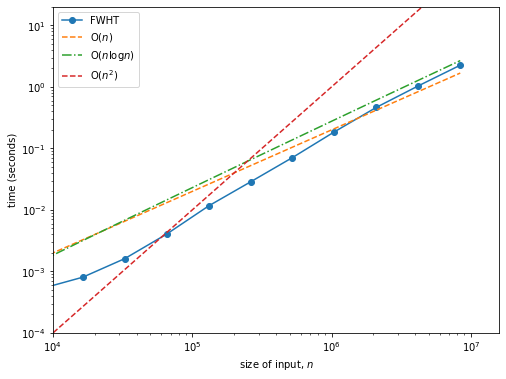

In [61]:
figure(figsize=(8, 6))
plt.xlim([1e4,16e6])
plt.ylim([1e-4,20])
plt.loglog( nList, times, 'o-', label='FWHT')
plt.loglog( nList, nList*2e-7, '--', label='O($n$)')
plt.loglog( nList, nList*np.log(nList)*2e-8, '-.', label='O($n \log n$)')
plt.loglog( nList, nList**2*1e-12, '--', label='O($n^2$)')
plt.xlabel('size of input, $n$')
plt.ylabel('time (seconds)')
plt.legend()
plt.show()